In [1]:
"""
Use complete_data_cleaned to build a Linear Regression model for adapted movies.

Feature engineering: scaling, polynomial, categorical features
Regularization: Ridge is better than LASSO but worse than baseline model

functions used:
get_Xy(df) from model.py
get_score(X_train,X_val,y_train,y_val) from model.py
categorical_multilabel(X_train,X_val,X_test,cat_variable) from model.py
categorical_singlelabel(X_train,X_val,X_test,cat_variable) from model.py


Result:

Validation set R^2 ~ 0.55
Test set R^2 ~ 0.59

Compared to only using movie data, movie + book data has improved R^
from 0.37 to 0.42

"""

'\nUse complete_data_cleaned_test to build a Linear Regression model for adapted movies.\n\nFeature engineering: scaling, polynomial, categorical features\nRegularization: Ridge is better than LASSO but worse than baseline model\n\nfunctions used:\nget_Xy(df) from model.py\nget_score(X_train,X_val,y_train,y_val) from model.py\ncategorical_multilabel(X_train,X_val,X_test,cat_variable) from model.py\ncategorical_singlelabel(X_train,X_val,X_test,cat_variable) from model.py\n\n\nResult:\n\nValidation set R^2 ~ 0.55\nTest set R^2 ~ 0.59\n\nCompared to only using movie data, movie + book data has improved R^\nfrom 0.37 to 0.42\n\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import patsy
import scipy.stats as stats

import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_2/py')
import importlib
from model import *

## 1. Prepare data

In [3]:
# Load the cleaned complete data
all_df = pd.read_pickle('../data/complete_data_cleaned')

# convert unit of 'opening_weekend_usa' to million dollors
all_df['opening_weekend_usa'] = all_df['opening_weekend_usa']/1e6

In [4]:
all_df.describe()

,rating,budget,opening_weekend_usa,gross_usa,gross_world,runtime,rating_value_b,rating_count_b,review_count_b,page,...,author_search,search_fiction_author,book_popularity,author_popularity,log_book_search,log_author_search,book_popularity_test,log_book_popularity,author_popularity_test,log_author_popularity
count,1135.000000,8.300000e+02,713.000000,1.135000e+03,8.420000e+02,1124.000000,1135.000000,1.135000e+03,1135.000000,1106.000000,...,8.810000e+02,8.810000e+02,872.000000,881.000000,881.000000,881.000000,880.000000,880.000000,881.000000,881.000000
mean,6.667313,2.846106e+07,9.598797,3.740295e+07,7.753742e+07,113.920819,3.875551,2.312974e+05,7510.383260,332.676311,...,2.068350e+07,1.636476e+08,0.086892,0.124288,8.561603,10.932581,0.122211,-4.003152,0.124289,-4.736478
std,0.905118,3.429356e+07,16.664456,4.785715e+07,1.450034e+08,23.305856,0.393255,5.965459e+05,16791.442166,171.545723,...,1.140401e+08,2.688862e+08,0.220079,0.436333,3.326120,3.810858,0.921601,1.942105,0.436334,2.619676
min,3.000000,3.000000e+04,0.000181,5.250000e+02,7.600000e+01,55.000000,0.000000,0.000000e+00,0.000000,0.000000,...,3.900000e+01,1.160000e+03,0.000000,0.000000,1.945910,3.663562,0.000012,-11.346477,0.000006,-11.959746
25%,6.100000,5.025000e+06,0.229292,1.096977e+07,5.916931e+06,99.000000,3.760000,2.808500e+03,218.500000,224.000000,...,3.100000e+03,1.330000e+05,0.010000,0.001200,6.021023,8.039157,0.005467,-5.209122,0.001168,-6.752070
50%,6.700000,1.800000e+07,4.163623,3.011468e+07,2.450694e+07,110.000000,3.920000,2.513900e+04,1314.000000,308.000000,...,2.430000e+04,1.720000e+07,0.020000,0.009200,7.859413,10.098232,0.017820,-4.027413,0.009167,-4.692182
75%,7.350000,3.575000e+07,11.515790,3.534301e+07,8.420588e+07,125.000000,4.070000,1.691815e+05,5807.000000,401.000000,...,6.210000e+05,1.690000e+08,0.060000,0.059600,10.561008,13.339086,0.068059,-2.687405,0.059615,-2.819842
max,9.200000,2.500000e+08,152.535747,4.080107e+08,1.033927e+09,280.000000,4.700000,7.292896e+06,173808.000000,1463.000000,...,1.860000e+09,1.220000e+09,2.420000,6.589700,18.403535,21.343842,26.369863,3.272222,6.589744,1.885514


In [5]:
# Clean columns
all_df['release_year'] = all_df['release_date'].dt.year
all_df['years_apart'] = all_df['release_year'] - all_df['publish_year']

all_df.rename(columns={'certificate':'MPAA'},inplace=True)
all_df.drop_duplicates(subset=['movie_title','release_year'],inplace=True)

# Load top 100 actor list
actor_list = pd.read_pickle('../dump/actor_top100_list')

In [6]:
# Remove outliers
all_df = all_df[all_df.opening_weekend_usa < 100]
all_df = all_df[all_df.movie_title != "Kiki's Delivery Service"]
# all_df = all_df[all_df.movie_title.isin(res_movie)]
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 0 to 1516
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   movie_title             708 non-null    object        
 1   rating                  708 non-null    float64       
 2   MPAA                    708 non-null    object        
 3   genre                   708 non-null    object        
 4   release_date            708 non-null    datetime64[ns]
 5   budget                  591 non-null    float64       
 6   opening_weekend_usa     708 non-null    float64       
 7   gross_usa               708 non-null    float64       
 8   gross_world             707 non-null    float64       
 9   runtime                 703 non-null    float64       
 10  director                708 non-null    object        
 11  writer                  708 non-null    object        
 12  actor                   708 non-null    object   

In [7]:
# all_df = all_df[all_df.movie_title.isin(res_movie) == False]

In [8]:
cat_feature = ['MPAA','genre','distributor','language','country']
con_feature = ['budget','runtime','film_count_d','avg_rating_d','avg_gross_d','release_year']
con_book_feature = ['years_apart','publish_year','page','log_book_popularity','log_author_popularity','count_a']
target_candidate = ['opening_weekend_usa','log_owu','gross_usa','gross_world','rating']

potential_feature = ['rating_value_b','rating_count_b','review_count_b']

In [9]:
# only continuous features for movie
c_movie_df = all_df[['opening_weekend_usa'] + con_feature].copy() 

# continuous features both movie and book
c_all_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature].copy()

# continuous feature both movie and book plus categorical variables
cc_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature + cat_feature].copy()

### Baseline Model
Only consider the continuous predictors and use 'opening_weekend_usa'. Compare using movie data only and using movie+book data.

#### * Only using movie data

In [10]:
X, y = get_Xy(c_movie_df)


Train R^2 score was: 0.44727559341990897
Validation R^2 score was: 0.37407604639466374
RMSE: 10.81 



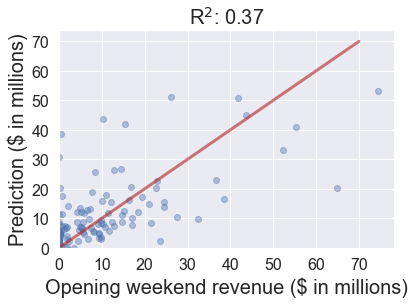

In [11]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
fig,lr,y_pred  = get_score(X_train,X_val,y_train,y_val)

In [12]:
fig.savefig('../plot/lr_prediction_m.pdf', bbox_inches='tight', transparent = True)

#### * Only movie + book data

In [13]:
X, y = get_Xy(c_all_df)


Train R^2 score was: 0.48815902816186296
Validation R^2 score was: 0.42104360425101417
RMSE: 10.01 



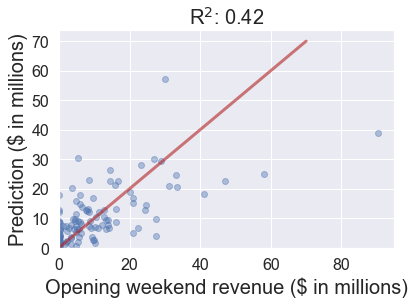

In [14]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
fig,lr,y_pred  = get_score(X_train,X_val,y_train,y_val)

In [15]:
fig.savefig('../plot/lr_prediction_b.pdf', bbox_inches='tight', transparent = True)

In [16]:
# Using both movie and book data increased R^2 from 0.36 to 0.42

## 2. Basic Feature Engineering

### Split the data set into Train / Validation / Test sets

In [17]:
# Use movie+book data
X, y = get_Xy(c_all_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

### * Scaled Features

In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [19]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled,y_train), lr.score(scaler.transform(X_val),y_val)

(0.48815902816186296, 0.42104360425121834)

In [20]:
lr.coef_

array([ 9.33799763,  0.15506341, -0.71482218, -0.84812158,  1.68615927,
        0.67112789, -0.13626359,  0.37234754,  0.57606768,  0.56067474,
        0.97201438,  0.85490126])

In [21]:
coef = pd.DataFrame(list(zip((con_feature+con_book_feature),lr.coef_)),\
                    index=con_feature+con_book_feature,\
                    columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
coef = coef[coef.Feature != 'T_book_age']
coef
# coef.index.tolist()

,Feature,Coefficient
budget,budget,9.337998
avg_gross_d,avg_gross_d,1.686159
log_author_popularity,log_author_popularity,0.972014
count_a,count_a,0.854901
release_year,release_year,0.671128
page,page,0.576068
log_book_popularity,log_book_popularity,0.560675
publish_year,publish_year,0.372348
runtime,runtime,0.155063
years_apart,years_apart,-0.136264


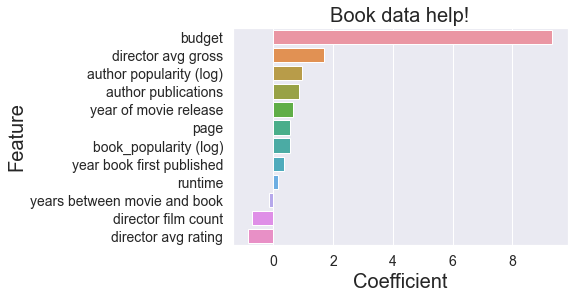

In [22]:
# Generate coef plots for the 3 continuous features
p = sns.color_palette("GnBu_r",3)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.set_palette(p)
sns.barplot(y="Feature", x= 'Coefficient', data = coef,orient='h')
ax.set_title('Book data help!',fontsize=20)
ax.set_ylabel('Feature',fontsize=20)
ax.set_xlabel('Coefficient',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_yticklabels(['budget',
 'director avg gross',
 'author popularity (log)',
 'author publications',
 'year of movie release',
 'page',
 'book_popularity (log)',
 'year book first published',
 'runtime',
 'years between movie and book',
 'director film count',
 'director avg rating'])

fig.savefig('../plot/lr_coef_book.pdf', bbox_inches='tight', transparent=True)
# fig.savefig('Top_station2.svg', format='svg')


Train R^2 score was: 0.48815902816186296
Validation R^2 score was: 0.42104360425101417
RMSE: 10.01 



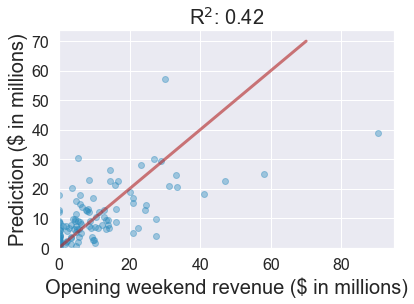

In [23]:
fig = get_score(X_train,X_val,y_train,y_val)

### * Polynomial Fearues
(degree=2): Adding interaction terms and second order feature.

In [24]:
# Choose df
# X, y = get_Xy(c_movie_df)
X, y = get_Xy(c_all_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

In [25]:
# Only with interaction terms
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = True)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.6338147380611499, -0.2791009818331145)

In [26]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train_poly_scaled, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: -0.607066320158298
[ 0.18357434  0.26149514  0.22847227 -0.59196765 -3.11690569]


In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = False)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.6504009168903095, -0.18662062527112044)

In [28]:
# increased train score, but decreased val score.
# overfitting

## 3. Intermediate Feature Engineering: Categorical features
Use `OneHotEncoder` or `pd.get_dummies(df['column'])` to treat categorical variables

#### * All categorical variables

In [29]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['actor']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [30]:

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['actor'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


# Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['actor'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


# Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [31]:
X_train.shape, X_val.shape

((345, 65), (115, 65))

In [32]:
# Quick evaluation
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train), lr.score(X_val,y_val)

(0.5729670561731262, 0.391757570838711)

In [33]:
# Still overfitting

## 4. Regularization

### * Ridge

In [34]:
## Fit a Ridge model on the standardized data

# ridge_model = Ridge(alpha = 0.001)
# ridge_model.fit(X_train,y_train)
# list(zip(X_train.columns, ridge_model.coef_))

In [35]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)
print('The best value of alpha is:', ridge_model.alpha_)

The best value of alpha is: 64.2403365939419


In [36]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 100)
ridge_model.fit(X_train,y_train)
list(zip(X_train.columns, ridge_model.coef_))

[('Scarlett Johansson', 0.010530525406587055),
 ('Anthony Hopkins', 0.21776051145644684),
 ('Gwyneth Paltrow', -0.051305115971970953),
 ('Edward Norton', -0.17337084185115506),
 ('Russell Crowe', -0.21383957090277683),
 ('budget runtime', 1.837757701403972),
 ('Drew Barrymore', 0.029353881241262484),
 ('Joaquin Phoenix', -0.08258408237303329),
 ('Willem Dafoe', 0.062739915815073),
 ('Sandra Bullock', 0.08081176418072304),
 ('budget avg_rating_d', -0.04022597305591769),
 ('runtime', 0.8800907750758874),
 ('avg_rating_d avg_gross_d', -1.3373531850788416),
 ('Charlize Theron', -0.008439912376644395),
 ('Colin Farrell', -0.22203852139501642),
 ('Harrison Ford', -0.041595237557327226),
 ('Hugh Jackman', 0.061473423242464235),
 ('Gene Hackman', 0.19023140741594827),
 ('film_count_d avg_rating_d', -0.02766413133654822),
 ('Renée Zellweger', -0.14814945002509802),
 ('Bill Murray', -0.0027904597517218015),
 ('Nicole Kidman', -0.2876681905908805),
 ('avg_rating_d', -0.2946271709973238),
 ('budge

In [37]:
top_key = pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_)),columns=['key','coef'])
top_key.sort_values(by='coef',ascending=False).head(20)

,key,coef
39,budget,5.271141
5,budget runtime,1.837758
63,avg_gross_d,1.530198
55,runtime avg_gross_d,1.103308
47,release_year,1.014235
60,film_count_d avg_gross_d,0.912676
11,runtime,0.880091
41,runtime film_count_d,0.775771
51,budget avg_gross_d,0.704390
23,budget^2,0.616256


In [38]:
# Quick evaluation
y_pred = ridge_model.predict(X_val)
r2_score(y_val, y_pred)

0.3858823447473123

In [39]:
# Similar to baseline model R^2

(0.0, 94.80935205)

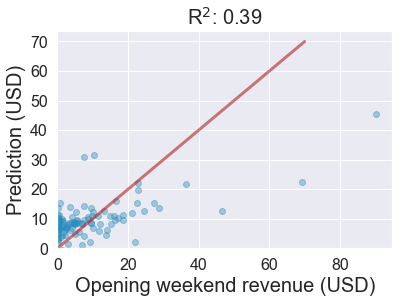

In [40]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

In [41]:
fig.savefig('../plot/ridge_prediction_b.pdf', bbox_inches='tight', transparent = True)

In [42]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

10.017792833305412

### * LASSO

In [43]:
# lasso_model = Lasso(alpha = 0.001)
# lasso_model.fit(X_train,y_train)
# list(zip(X_train_con_scaled_df.columns, lasso_model.coef_))

In [44]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha


alphavec = 10**np.linspace(-5,5,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)
print('The best value of alpha is:', lasso_model.alpha_)

The best value of alpha is: 0.8412497049736118


In [45]:
lasso_model = Lasso(alpha = 32.1)
lasso_model.fit(X_train,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('Scarlett Johansson', -0.0),
 ('Anthony Hopkins', 0.0),
 ('Gwyneth Paltrow', -0.0),
 ('Edward Norton', -0.0),
 ('Russell Crowe', -0.0),
 ('budget runtime', 0.0),
 ('Drew Barrymore', -0.0),
 ('Joaquin Phoenix', -0.0),
 ('Willem Dafoe', -0.0),
 ('Sandra Bullock', 0.0),
 ('budget avg_rating_d', 0.0),
 ('runtime', 0.0),
 ('avg_rating_d avg_gross_d', 0.0),
 ('Charlize Theron', 0.0),
 ('Colin Farrell', -0.0),
 ('Harrison Ford', 0.0),
 ('Hugh Jackman', 0.0),
 ('Gene Hackman', 0.0),
 ('film_count_d avg_rating_d', 0.0),
 ('Renée Zellweger', -0.0),
 ('Bill Murray', -0.0),
 ('Nicole Kidman', 0.0),
 ('avg_rating_d', 0.0),
 ('budget^2', 0.0),
 ('Susan Sarandon', 0.0),
 ('avg_gross_d release_year', 0.0),
 ('John Goodman', -0.0),
 ('Bruce Willis', -0.0),
 ('avg_gross_d^2', 0.0),
 ('runtime avg_rating_d', -0.0),
 ('Julianne Moore', 0.0),
 ('film_count_d', 0.0),
 ('Meryl Streep', -0.0),
 ('Jack Nicholson', -0.0),
 ('Kevin Spacey', -0.0),
 ('avg_rating_d^2', -0.0),
 ('Tom Hanks', 0.0),
 ('avg_rating_d

In [46]:
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)),columns=['Feature','Coefficient'])
lasso_top = lasso_coef.sort_values(by=['Coefficient'],ascending=False).head(20)
lasso_top

,Feature,Coefficient
0,Scarlett Johansson,-0.0
33,Jack Nicholson,-0.0
35,avg_rating_d^2,-0.0
36,Tom Hanks,0.0
37,avg_rating_d release_year,0.0
38,Matt Damon,0.0
39,budget,0.0
40,Sylvester Stallone,-0.0
41,runtime film_count_d,0.0
42,runtime release_year,0.0


In [47]:
# only page, budget, director average gross are left
# but coefficients not meaning ful since all features are small

In [48]:
y_pred = lasso_model.predict(X_val)
r2_score(y_val, y_pred)

-0.06698318004980996

(0.0, 94.80935205)

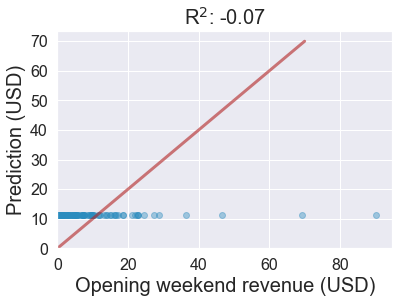

In [49]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)